# Implementation of a Devito acoustic Least-square Reverse time migration

## This tutorial is contributed by SENAI CIMATEC (2021)

This tutorial is based on:

<br>**LEAST-SQUARES REVERSE TIME MIGRATION (LSRTM) IN THE SHOT DOMAIN** (2016)
<br>Antonio Edson Lima de Oliveira, Reynam da Cruz Pestana and Adriano Wagner Gomes dos Santos
<br>Brazilian Journal of Geopyisics
<br>http://dx.doi.org/10.22564/rbgf.v34i3.831

<br>**Plane-wave least-squares reverse-time migration** (2013)
<br>Wei Dai and Gerard T. Schuster
<br>GEOPHYSICS Technical Papers 
<br>http://dx.doi.org/10.22564/rbgf.v34i3.831

<br>**Two-point step size gradient method** (1988)
<br>Barzilai, J. and Borwein, J. 
<br>IMA Journal of Numerical Analysis 
<br>https://doi.org/10.1093/imanum/8.1.141

## Introduction 
The goal of this tutorial is to implement and validate the Least-squares reverse time migration (LSRTM) using a 2D three-layered velocity model with a square in the middle. The algorithm has been implemented using the Born's appoximation.

The acoustic wave equation for constant density is:

\begin{equation}
 m_{0} \dfrac{\partial^2 p_0 }{\partial t^2} - \nabla^2 p_0 = s (\mathbf{x},t)   \hspace{0.5cm}     (1)
\end{equation}

where $s (\mathbf{x},t) $ is the source, $p_{0}$ is the background wavefield and $m_{0}$ is the smoothed squared slowness.

A perturbation in the squared slowness $m = m_{0} + \delta m$ produces a background wavefield ( $p_{0}$ ) and scattered wavefield ( $\delta p$ ), so the wavefield $p$ is approximated to $ p = p_0 + \delta p$, that obeys the relation:

\begin{equation}
 m \dfrac{\partial^2 p}{\partial t^2} - \nabla^2 p = s (\mathbf{x},t)   \hspace{0.5cm}     (2)
\end{equation}


Using the approximation of $p$ and $m$ into equation (2),

\begin{equation}
 (m_{0} + \delta m) \dfrac{\partial^2 (p_0 + \delta p)}{\partial t^2} - \nabla^2 (p_0 + \delta p) = s (\mathbf{x},t)   \hspace{0.5cm}     (3)
\end{equation}

Expanding equation (3) we have:
\begin{equation}
m_{0} \dfrac{\partial^2 p_0 }{\partial t^2} - \nabla^2 p_0 + m_{0} \dfrac{\partial^2 \delta p }{\partial t^2} - \nabla^2\delta p + \delta m \dfrac{\partial^2 (p_{0} +\delta p) }{\partial t^2}= s (\mathbf{x},t) \hspace{0.5cm}    (4)
\end{equation}

Reordering the equation (5), 
\begin{equation}
m_{0} \dfrac{\partial^2 p_0 }{\partial t^2} - \nabla^2 p_0 + m_{0} \dfrac{\partial^2 \delta p }{\partial t^2} - \nabla^2\delta p = s (\mathbf{x},t) - \delta m \dfrac{\partial^2 (p_{0} +\delta p) }{\partial t^2} \hspace{0.5cm}    (5)
\end{equation}

Considering that $ \delta m \dfrac{\partial^2 (p_{0} +\delta p) }{\partial t^2} = \delta m \dfrac{\partial^2 p }{\partial t^2} \approx \delta m \dfrac{\partial^2 p_{0} }{\partial t^2}  $( Via Born's approximation $p\approx p_{0}$ ):

\begin{equation}
m_{0} \dfrac{\partial^2 p_0 }{\partial t^2} - \nabla^2 p_0 + m_{0} \dfrac{\partial^2 \delta p }{\partial t^2} - \nabla^2\delta p = s (\mathbf{x},t) -\delta m \dfrac{\partial^2 p_{0} }{\partial t^2}\hspace{0.5cm}    (6)
\end{equation}

Now we can create an equations system:

\begin{equation}
 \left\{
\begin{array}{lcl}
m_{0} \dfrac{\partial^2 p_0 }{\partial t^2} - \nabla^2 p_0 = s (\mathbf{x},t),\hspace{0.5cm} (7a) \\
m_{0} \dfrac{\partial^2 \delta p }{\partial t^2} - \nabla^2\delta p = - \delta m \dfrac{\partial^2 p_{0} }{\partial t^2} \hspace{0.5cm} (7b) \\
\end{array}
\right.
\end{equation}

Equations (7a) and (7b) are for Born modelling. The adjoint modelling is defined by the equation:
 
\begin{equation}
m_{0} \dfrac{\partial^2 v}{\partial t^2} - \nabla^2 v =\textbf{d}  \hspace{0.5cm}     (8)
\end{equation}
where $\textbf{d}$ is the shot recorded.

With all these equations, the migrated image can be constructed

\begin{equation}
\mathbf{m}= \sum_{t} \dfrac{\partial^2 p_0}{\partial t^2}v \hspace{0.5cm}     (9)
\end{equation}

In this notebook the migration and gradient has been precoditioned by the source illumination, so equation (9) becomes:

\begin{equation}
\mathbf{m}=  \frac{\sum_{t} \dfrac{\partial^2 p_0}{\partial t^2}v}{\sum_{t} p_{0}^2} \hspace{0.5cm}     (10)
\end{equation}


The Least-square reverse time migration is an iterative method. After a first migration is done, the image is update iteratively

\begin{equation}
\textbf{m}_{k+1} = \textbf{m}_k -\alpha_k \textbf{g}_k \hspace{0.5cm}     (11)
\end{equation}
where $\textbf{g}_k$ is the gradient and $\alpha_k$ is the step-length. The gradient computation is simply taking equation (9) and instead of injecting the shot recorded $\textbf{d}$, injects the residue $\textbf{d}_{calc}-\textbf{d}_{obs}$

For now we are going to import the utilities.

In [1]:
%matplotlib inline
import numpy as np

from devito import Operator,Eq,solve,Grid,SparseFunction,norm
from devito import TimeFunction,Function
from devito import gaussian_smooth
from devito import mmax

from devito.logger import info

from examples.seismic import Model
from examples.seismic import plot_velocity,plot_shotrecord
from examples.seismic import Receiver
from examples.seismic import PointSource
from examples.seismic import plot_image,AcquisitionGeometry
from examples.seismic import TimeAxis

from examples.seismic.self_adjoint import (setup_w_over_q)
from examples.seismic.acoustic import AcousticWaveSolver

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.ticker as plticker

from devito import configuration
configuration['log-level'] = 'WARNING'

# Seismic modelling with Devito

Now let's import all the parameters needed and create the true 2D velocity model and the smoothed model to perform the Born's modelling.

In [2]:
shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # What is the location of the top left corner. This is necessary to define

fpeak = 0.010
t0w = 1.0 / fpeak
omega = 2.0 * np.pi * fpeak
qmin = 0.1
qmax = 100000
npad=50
dtype = np.float32

nshots = 21
nreceivers = 101
t0 = 0.
tn = 1000.  # Simulation last 1 second (1000 ms)
f0 = 0.025  # Source peak frequency is 10Hz (0.010 kHz)
filter_sigma = (5, 5) # Filter's length

v = np.empty(shape, dtype=dtype)

# Define a velocity profile. The velocity is in km/s
vp_top = 1.5

v[:] = vp_top # Top velocity 
v[:, 30:65]= vp_top +0.5
v[:, 65:101]= vp_top +1.5
v[40:60, 35:55]= vp_top+1

init_damp = lambda func, nbl: setup_w_over_q(func, omega, qmin, qmax, npad, sigma=0)
model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=8, bcs=init_damp,nbl=npad,dtype=dtype)
model0 = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=8, bcs=init_damp,nbl=npad,dtype=dtype)

dt = model.critical_dt 
s = model.grid.stepping_dim.spacing
time_range = TimeAxis(start=t0, stop=tn, step=dt)
nt=time_range.num

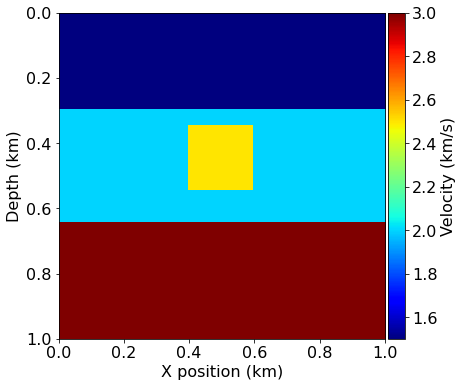

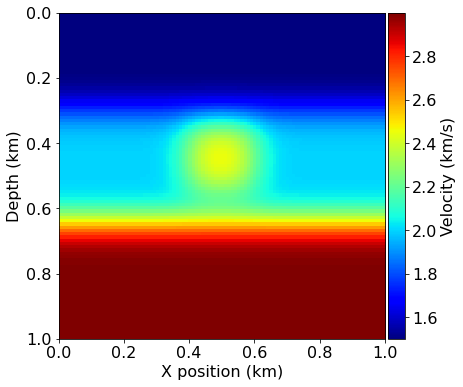

In [3]:
#NBVAL_IGNORE_OUTPUT
# Create initial model and smooth the boundaries
gaussian_smooth(model0.vp, sigma=filter_sigma)
# Plot the true and initial model
plot_velocity(model)
plot_velocity(model0)

Now we are going to set the source and receiver position.

In [4]:
# First, position source centrally in all dimensions, then set depth
src_coordinates = np.empty((1, 2))
src_coordinates[0, :] = np.array(model.domain_size) * .5
src_coordinates[0, -1] = 30.  

# Define acquisition geometry: receivers

# Initialize receivers for synthetic and imaging data
rec_coordinates = np.empty((nreceivers, 2))
rec_coordinates[:, 0] = np.linspace(0, model.domain_size[0], num=nreceivers)
rec_coordinates[:, 1] = 30.

# Geometry
geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, t0, tn, f0=.025, src_type='Ricker')

solver = AcousticWaveSolver(model, geometry, space_order=8)

In [5]:
source_locations = np.empty((nshots, 2), dtype=dtype)
source_locations[:, 0] = np.linspace(0., 1000, num=nshots)
source_locations[:, 1] = 30. # Depth is 30m

We are going to compute the LSRTM gradient.

In [6]:
def lsrtm_gradient(dm):
    
    residual = Receiver(name='residual', grid=model.grid, time_range=geometry.time_axis,
                        coordinates=geometry.rec_positions)
    
    d_obs = Receiver(name='d_obs', grid=model.grid,time_range=geometry.time_axis,
                         coordinates=geometry.rec_positions)

    d_syn = Receiver(name='d_syn', grid=model.grid,time_range=geometry.time_axis,
                         coordinates=geometry.rec_positions)
    
    grad_full = Function(name='grad_full', grid=model.grid)
    
    grad_illum = Function(name='grad_illum', grid=model.grid)
    
    src_illum = Function (name ="src_illum", grid = model.grid)

    # Using devito's reference of virtual source
    dm_true =  (solver.model.vp.data**(-2) - model0.vp.data**(-2))
    
    objective = 0.
    for i in range(nshots):
        
        #Observed Data using Born's operator
        geometry.src_positions[0, :] = source_locations[i, :]

        _, u0, _ = solver.forward(vp=model0.vp, save=True)
        
        _, _, _,_ = solver.jacobian(dm_true, vp=model0.vp, rec = d_obs)
        
        #Calculated Data using Born's operator
        solver.jacobian(dm, vp=model0.vp, rec = d_syn)
        
        residual.data[:] = d_syn.data[:]- d_obs.data[:]
     
        grad_shot,_ = solver.gradient(rec=residual, u=u0, vp=model0.vp)
        
        src_illum_upd =  Eq(src_illum, src_illum + u0**2)
        op_src = Operator([src_illum_upd])
        op_src.apply()
              
        grad_sum = Eq(grad_full, grad_full  + grad_shot)
        op_grad = Operator([grad_sum])
        op_grad.apply()
        
        grad_f = Eq(grad_illum, grad_full/(src_illum+10-9))
        op_gradf = Operator([grad_f])
        op_gradf.apply()
                
        objective += .5*norm(residual)**2
     
    return objective,grad_illum,d_obs,d_syn

For the first LSRTM iteration, we used a quite simple step-length using the maximum value of the gradient. For the other LSRTM iterations we used the step-length proposed by Barzilai Borwein.
\begin{equation}
\alpha_{k}^{BB1} = \frac{\mathbf{s}_{k-1}^{T}\mathbf{s}_{k-1}}{\mathbf{s}_{k-1}^{T}\mathbf{y}_{k-1}}
\end{equation}
where $\textbf{s}_{k-1} = \textbf{m}_{k}-\textbf{m}_{k-1}$ e $\textbf{y}_{k-1} = \textbf{g}_{k}-\textbf{g}_{k-1}$

A second option is:
\begin{equation}
\alpha_{k}^{BB2} = \frac{\mathbf{s}_{k-1}^{T}\mathbf{y}_{k-1}}{\mathbf{y}_{k-1}^{T}\mathbf{y}_{k-1}}
\end{equation}

\begin{equation}
\alpha_{k} = 
\begin{cases}
\alpha_{k}^{BB2},& \text{if}\ 0 < \frac{\alpha_{k}^{BB2}}{\alpha_{k}^{BB1}} < 1 \\
\alpha_{k}^{BB1},& \text{else}
\end{cases}
\end{equation}

In [7]:
def get_alfa(grad_iter,image_iter,niter_lsrtm):
    
     
    term1 = np.dot(image_iter.reshape(-1), image_iter.reshape(-1))
    
    term2 = np.dot(image_iter.reshape(-1), grad_iter.reshape(-1))
    
    term3 = np.dot(grad_iter.reshape(-1), grad_iter.reshape(-1))
    
    if niter_lsrtm == 0:
           
        alfa = .05 / mmax(grad_full)
    
    else:
        abb1 = term1 / term2
        
        abb2 = term2 / term3
        
        abb3 = abb2 / abb1
        
        if abb3 > 0 and abb3 < 1:
            alfa = abb2
        else:
            alfa = abb1
            
    return alfa   

Now is the kernel of the LSRTM. The migration will be updated iteratively, using the step-length and the gradient.

In [8]:
#NBVAL_IGNORE_OUTPUT
image_up_dev = np.zeros((model0.vp.shape[0], model0.vp.shape[1]),dtype)

image = np.zeros((model0.vp.shape[0], model0.vp.shape[1]))

nrec=101
niter=20 # number of iterations of the LSRTM
history = np.zeros((niter, 1)) #objective function

image_prev = np.zeros((model0.vp.shape[0],model0.vp.shape[1]))
    
grad_prev  = np.zeros((model0.vp.shape[0],model0.vp.shape[1]))

yk  = np.zeros((model0.vp.shape[0],model0.vp.shape[1]))

sk = np.zeros((model0.vp.shape[0],model0.vp.shape[1]))

for k in range(niter) :
    
    dm =  image_up_dev # Reflectivity for Calculated data via Born

    print('LSRTM Iteration',k+1)
        
    objective,grad_full,d_obs,d_syn = lsrtm_gradient(dm)
      
    history[k] = objective
     
    yk = grad_full.data - grad_prev
    
    sk = image_up_dev - image_prev

    alfa = get_alfa(yk,sk,k)
    
    grad_prev = grad_full.data

    image_prev = image_up_dev
      
    image_up_dev = image_up_dev - alfa*grad_full.data
      
    if k == 0: # Saving the first migration using Born operator.
        
        image = image_up_dev

LSRTM Iteration 1
LSRTM Iteration 2
LSRTM Iteration 3
LSRTM Iteration 4
LSRTM Iteration 5
LSRTM Iteration 6
LSRTM Iteration 7
LSRTM Iteration 8
LSRTM Iteration 9
LSRTM Iteration 10
LSRTM Iteration 11
LSRTM Iteration 12
LSRTM Iteration 13
LSRTM Iteration 14
LSRTM Iteration 15
LSRTM Iteration 16
LSRTM Iteration 17
LSRTM Iteration 18
LSRTM Iteration 19
LSRTM Iteration 20


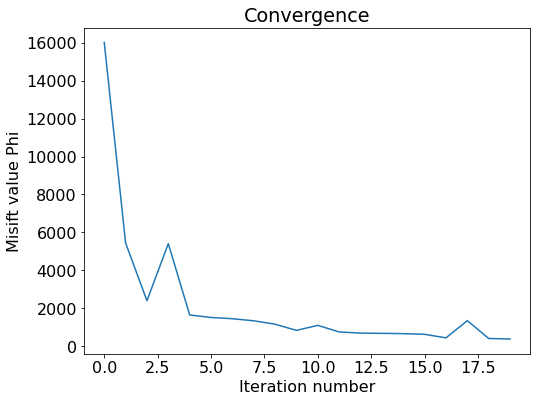

In [9]:
#NBVAL_SKIP
plt.figure()
plt.plot(history)
plt.xlabel('Iteration number')
plt.ylabel('Misift value Phi')
plt.title('Convergence')
plt.show()

In [10]:
def plot_image(data, vmin=None, vmax=None, colorbar=True, cmap="gray"):
    """
    Plot image data, such as RTM images or FWI gradients.

    Parameters
    ----------
    data : ndarray
        Image data to plot.
    cmap : str
        Choice of colormap. Defaults to gray scale for images as a
        seismic convention.
    """
    domain_size = 1.e-3 * np.array(model.domain_size)
    extent = [model.origin[0], model.origin[0] + domain_size[0],
              model.origin[1] + domain_size[1], model.origin[1]]
    plot = plt.imshow(np.transpose(data),
                      vmin=-.05,
                      vmax=.05,
                      cmap=cmap,extent=extent)
    
    plt.xlabel('X position (km)')
    plt.ylabel('Depth (km)')

    # Create aligned colorbar on the right
    if colorbar:
        ax = plt.gca()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(plot, cax=cax)
    plt.show()


The image below is our first migration. The reflectors are not well focused and backscaterring noise is very strong.

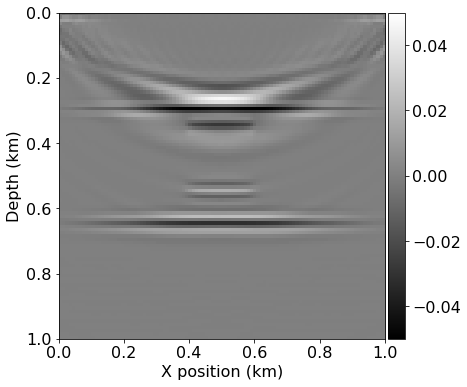

In [11]:
#NBVAL_IGNORE_OUTPUT
slices=tuple(slice(model.nbl,-model.nbl) for _ in range(2))
rtm = image[slices]
plot_image(np.diff(rtm, axis=1))

So here we have the LSRTM migration after 20 iterations, it is clear that the reflector is well focused and backscaterring noise has been strongly attenuated.

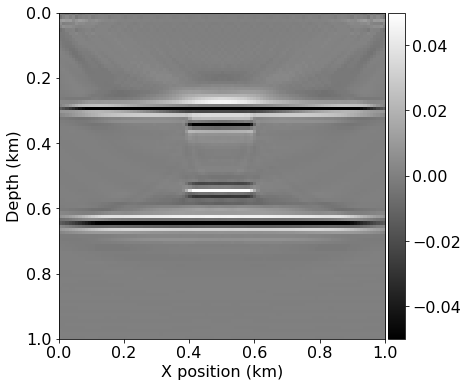

In [12]:
#NBVAL_SKIP
slices=tuple(slice(model.nbl,-model.nbl) for _ in range(2))
lsrtm = image_up_dev[slices]
plot_image(np.diff(lsrtm, axis=1))

Here we have the true reflectivity. The idea in showing it is to demonstrate that the amplitude range of the LSRTM is in the same amplitude range of the true reflectivity.

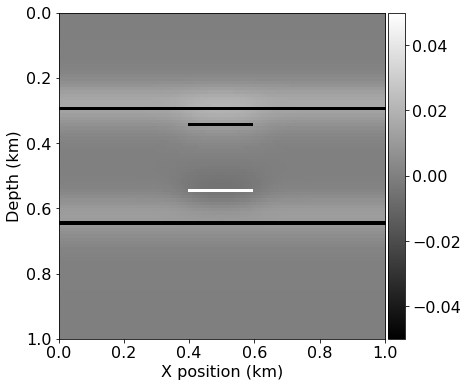

In [13]:
#NBVAL_IGNORE_OUTPUT
slices=tuple(slice(model.nbl,-model.nbl) for _ in range(2))
dm_true = (solver.model.vp.data**(-2) - model0.vp.data**(-2))[slices]
plot_image(np.diff(dm_true, axis=1))

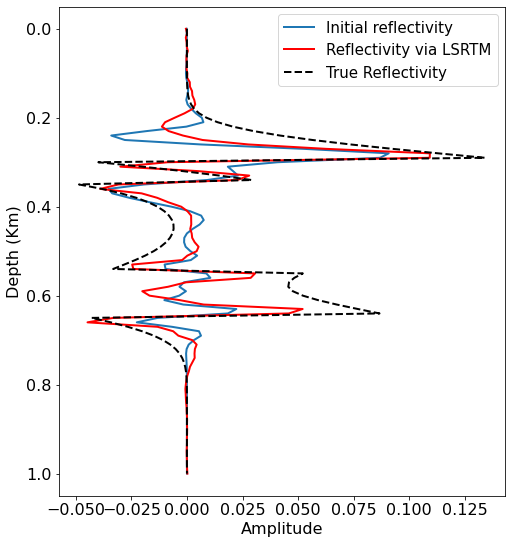

In [14]:
#NBVAL_SKIP
plt.figure(figsize=(8,9))
x = np.linspace(0,1,101)
plt.plot(rtm[50,:],x,color=plt.gray(),linewidth=2)
plt.plot(lsrtm[50,:],x,'r',linewidth=2)
plt.plot(dm_true[50,:],x, 'k--',linewidth=2)

plt.legend(['Initial reflectivity', 'Reflectivity via LSRTM','True Reflectivity'],fontsize=15)
plt.ylabel('Depth (Km)')
plt.xlabel('Amplitude')
plt.gca().invert_yaxis()
plt.show()

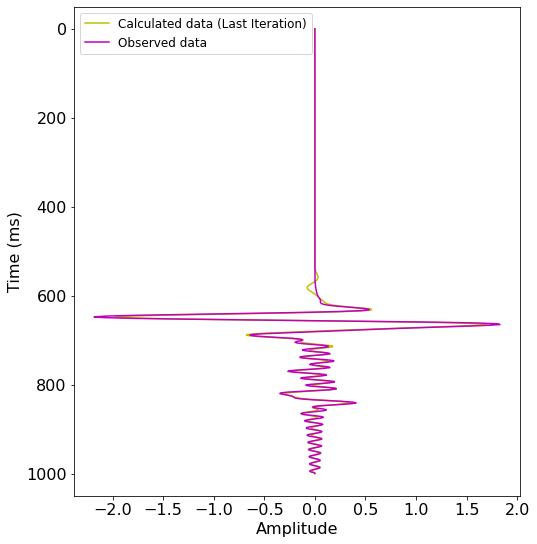

In [15]:
#NBVAL_SKIP
time = np.linspace(t0, tn, nt)
plt.figure(figsize=(8,9))
plt.ylabel('Time (ms)')
plt.xlabel('Amplitude')
plt.plot(d_syn.data[:, 20],time, 'y', label='Calculated data (Last Iteration)')
plt.plot(d_obs.data[:, 20],time, 'm', label='Observed data')
plt.legend(loc="upper left",fontsize=12)
ax = plt.gca()
ax.invert_yaxis()
plt.show()